# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
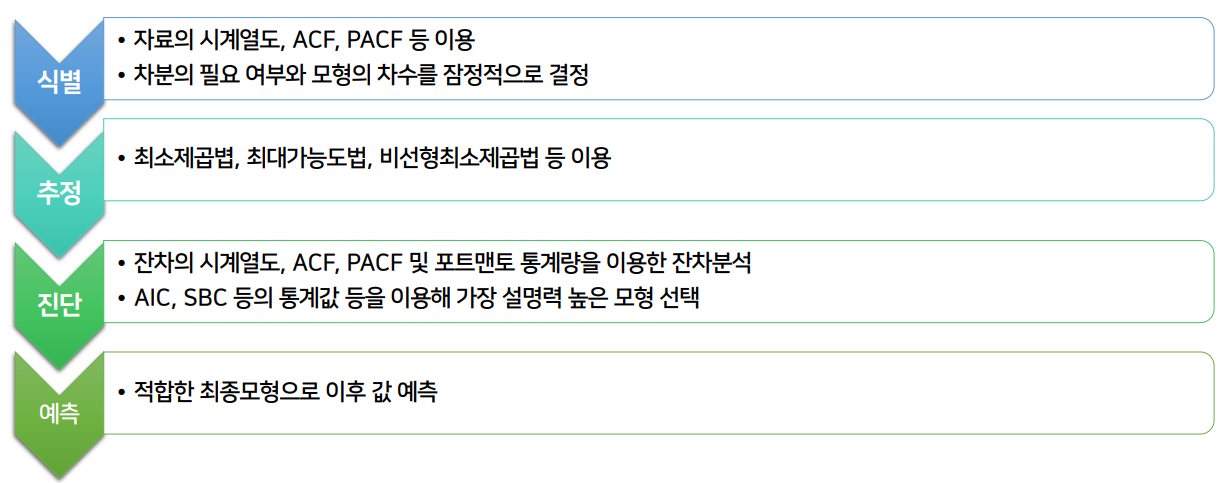

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [94]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMAResults

import warnings
warnings.filterwarnings("ignore")

## 데이터 불러오기

In [95]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


## 1. 식별

#### ⅰ) 시계열도 그리기

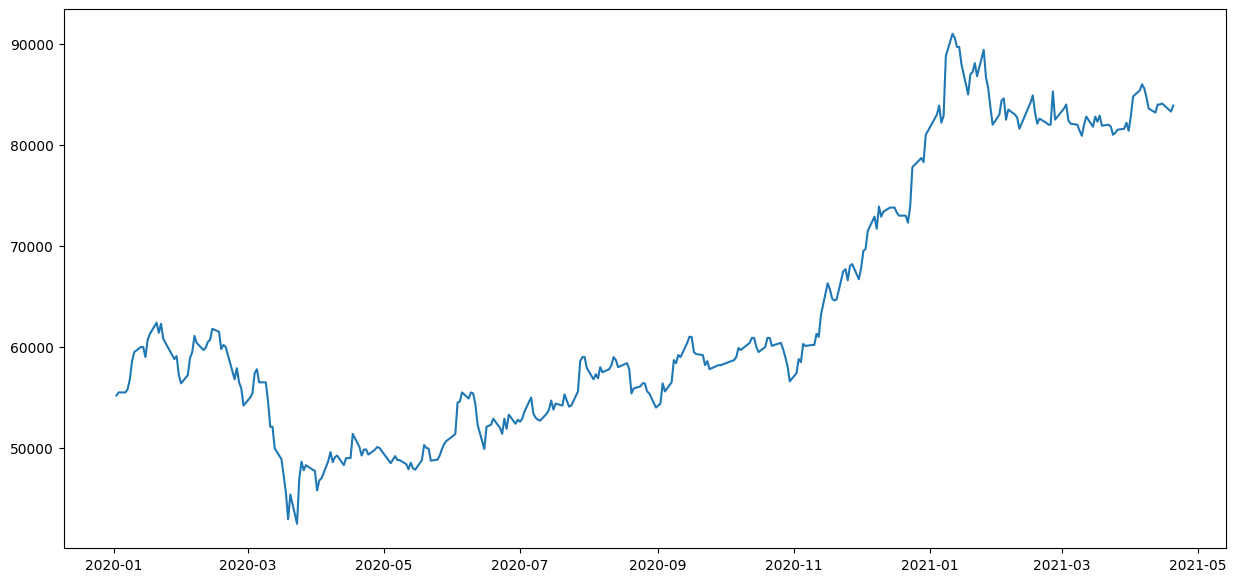

In [3]:
# price에 대한 시계열 그림
plt.figure(figsize=(15,7))
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show()

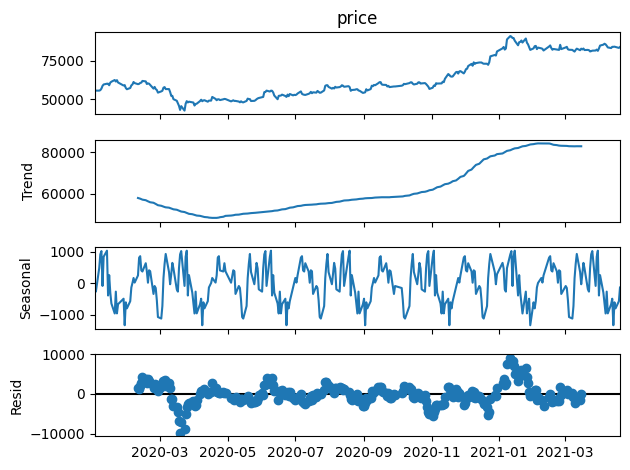

In [4]:
# 분해
a = seasonal_decompose(x = samsung_df["price"], model = "add", period=50)
a.plot();

- Trend : 주어진 데이터의 추세는 시간에 따라 증가하는 형태이고
- Seasonal : 계절성이 존재한다. 
- Resid : 정상성은 만족하지 않는 것으로 보인다.

#### ⅱ) 정상성 만족 여부 판단 - ACF, PACF 그리기

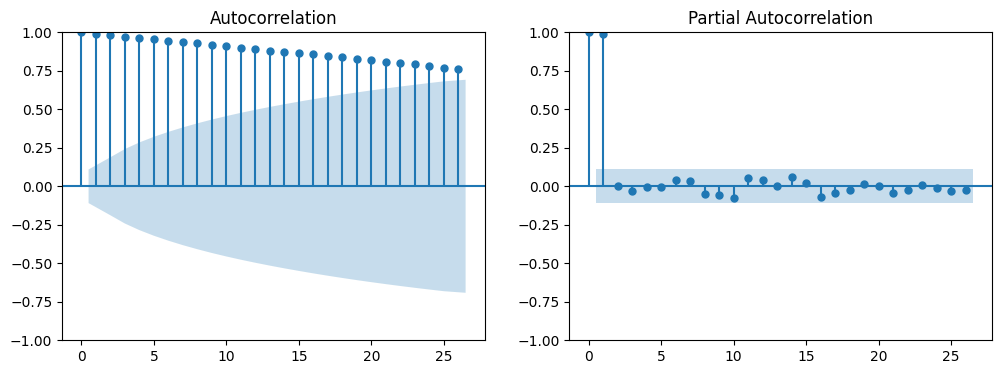

In [5]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 시각화
# subplot생성
fig, ax = plt.subplots(1, 2, figsize = (12,4))

# acf plot
plot_acf(samsung_df['price'], ax = ax[0])

# pacf plot
plot_pacf(samsung_df['price'], ax= ax[1])
plt.show()

- ACF : 원데이터의 ACF 도표를 보면 매우 천천히 correlation이 내려가고 신뢰구간 안에 들어가지 못하므로 안정적이지 않다.
- PACF : PACF는 1의 Time lag 이후 0으로 수렴한다.

따라서 p=0, q=1 이 적당해 보인다.

#### 차분

In [5]:
#차분을 위한 lag_1 열 생성
result = samsung_df['price'].to_frame(name="price")  # 차분을 위해 동일한 데이터를 하나 더 만든다.
result = result.loc[::-1]                            # 데이터의 행을 역순으로 뒤집는다.
result["lag_1"] = result["price"].shift(periods=1)   # shift 함수를 이용해 t개의 데이터를 t-1 개로 밀어낸다.

print(result)

              price    lag_1
day                         
2021-04-20  83900.0      NaN
2021-04-19  83300.0  83900.0
2021-04-16  83900.0  83300.0
2021-04-15  84100.0  83900.0
2021-04-14  84000.0  84100.0
...             ...      ...
2020-01-08  56800.0  58600.0
2020-01-07  55800.0  56800.0
2020-01-06  55500.0  55800.0
2020-01-03  55500.0  55500.0
2020-01-02  55200.0  55500.0

[322 rows x 2 columns]


In [6]:
#차분
result['diff_1'] = result['price'] - result['lag_1'] 
print(result)

              price    lag_1  diff_1
day                                 
2021-04-20  83900.0      NaN     NaN
2021-04-19  83300.0  83900.0  -600.0
2021-04-16  83900.0  83300.0   600.0
2021-04-15  84100.0  83900.0   200.0
2021-04-14  84000.0  84100.0  -100.0
...             ...      ...     ...
2020-01-08  56800.0  58600.0 -1800.0
2020-01-07  55800.0  56800.0 -1000.0
2020-01-06  55500.0  55800.0  -300.0
2020-01-03  55500.0  55500.0     0.0
2020-01-02  55200.0  55500.0  -300.0

[322 rows x 3 columns]


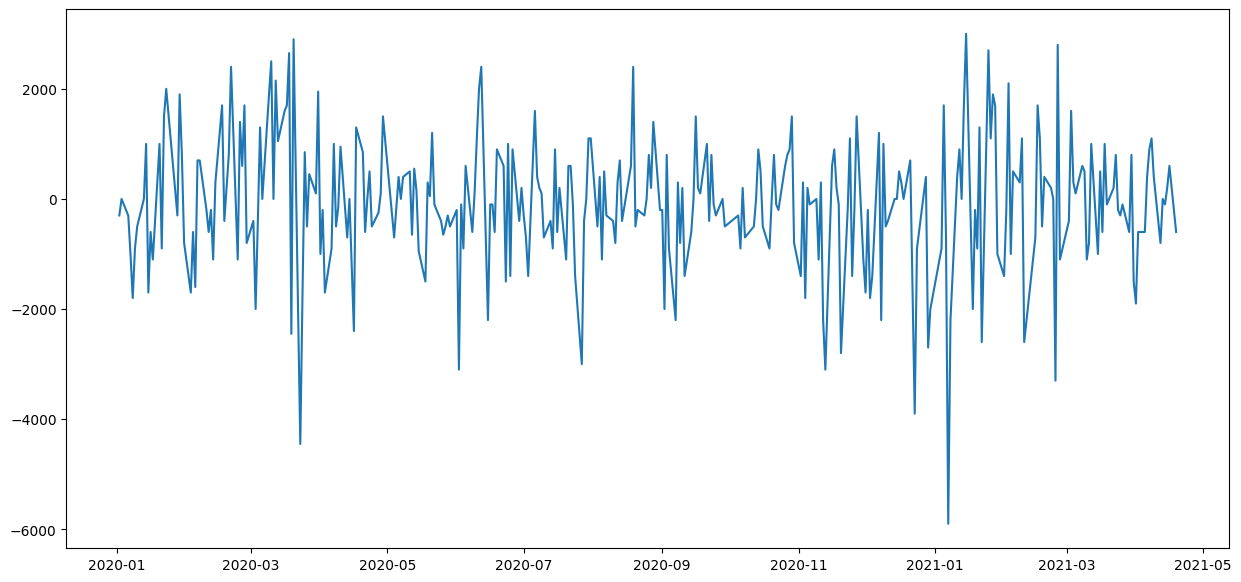

In [7]:
#1차 차분한 데이터 시계열도 그리기
plt.figure(figsize=(15,7))
plt.plot(result.index, result["diff_1"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show()

In [8]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(result["diff_1"].dropna(), autolag='AIC')
pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])

Test Statistic                -1.761089e+01
p-value                        3.880127e-30
Lags Used                      0.000000e+00
Number of Observations Used    3.200000e+02
dtype: float64

정상시계열이 아니라는 귀무가설은 0.05의 유의수준에 의해 기각된다.   
따라서 ADF test에 의하면 1차 차분된 데이터는 정상성을 만족한다.

잠정모형은 ARIMA(0,1,1) 로 한다.

## 2. 추정

#### 최적 ARIMA 모형 찾기

SARIMAX : ARIMAX 모형에서 계절성 패턴을 추가한 모델    
→ 추세에 대한 ARIMA를 수행하고, 계절성에 추가적으로 ARIMA 수행

In [96]:
# ARIMA(0,1,1) 모형 적합해보기
arima_model = sm.tsa.statespace.SARIMAX(samsung_df["price"], order=(0,1,1), seasonal_order = (4,0,3,12))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      price   No. Observations:                  322
Model:             SARIMAX(0, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -2733.168
Date:                                    Sun, 27 Aug 2023   AIC                           5484.336
Time:                                            20:04:16   BIC                           5518.279
Sample:                                                 0   HQIC                          5497.889
                                                    - 322                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0133      0.047      0.281      0.779      -0.079       0.106
ar.S.L12      -0.1769      0.145     -1.219      0.223      -0.461       0.108
ar.S.L24       0.1682      0.192      0.877      0.380      -0.208       0.544
ar.S.L36       0.9772      0.066     14.713      0.000       0.847       1.107
ar.S.L48       0.0093      0.055      0.168      0.866      -0.099       0.118
ma.S.L12       0.1978      0.175      1.131      0.258      -0.145       0.540
ma.S.L24      -0.1642      0.227     -0.723      0.469      -0.609       0.281
ma.S.L36      -0.9779      0.122     -7.990      0.000      -1.218      -0.738
sigma2      1.513e+06   1.67e-07   9.05e+12      0.000    1.51e+06    1.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                33.70
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.44
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.53e+28. Standard errors may be unstable.
"""

유의하지 않은 모수가 많으므로 ARIMA(0,1,1) 모형은 기각하고, 최적 모형을 찾아보겠다.

In [97]:
# 최적의 모수 찾기

import itertools
p=q=range(0,3) # p,q가 각각 0부터 2까지의 값일 때

# trend에 대한 모수들
trend_pdq = list(itertools.product(p,[1],q))

# seasonal에 대한 모수들
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]



## SARIMAX
AIC = []
SARIMAX_order = []

for trend_param in trend_pdq:
    for seasonal_params in seasonal_pdq:
        try:
            # 파라미터를 넣어가며 모델 생성
            arima_model = sm.tsa.statespace.SARIMAX(samsung_df["price"], 
                                                    order=trend_param, 
                                                    seasonal_order = seasonal_params)
            result = arima_model.fit()
            # 모델별 추세, 계절별 모수와 aic, bic 출력
            print('SARIMAX{}X{}, AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            # aic 리스트에 삽입
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
            
            
        except:
            continue
            
            
##가장 작은 AIC를 가지는 모수 출력
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0],
                                                             SARIMAX_order[AIC.index(min(AIC))][1]))

SARIMAX(0, 1, 0)X(0, 1, 0, 12), AIC=5488.1142080284935, BIC=5491.847549305391
SARIMAX(0, 1, 0)X(0, 1, 1, 12), AIC=5442.487231063936, BIC=5449.953913617731
SARIMAX(0, 1, 0)X(0, 1, 2, 12), AIC=5425.161689934014, BIC=5436.361713764708
SARIMAX(0, 1, 0)X(1, 1, 0, 12), AIC=5457.438643236923, BIC=5464.905325790718
SARIMAX(0, 1, 0)X(1, 1, 1, 12), AIC=5420.344936172469, BIC=5431.5449600031625
SARIMAX(0, 1, 0)X(1, 1, 2, 12), AIC=5422.198965791928, BIC=5437.132330899519
SARIMAX(0, 1, 0)X(2, 1, 0, 12), AIC=5447.895988278609, BIC=5459.096012109303
SARIMAX(0, 1, 0)X(2, 1, 1, 12), AIC=5422.207351517455, BIC=5437.1407166250465
SARIMAX(0, 1, 0)X(2, 1, 2, 12), AIC=5420.50962456828, BIC=5439.176330952769
SARIMAX(0, 1, 1)X(0, 1, 0, 12), AIC=5488.109165611833, BIC=5495.5758481656285
SARIMAX(0, 1, 1)X(0, 1, 1, 12), AIC=5443.234006271021, BIC=5454.434030101715
SARIMAX(0, 1, 1)X(0, 1, 2, 12), AIC=5425.450265333195, BIC=5440.383630440786
SARIMAX(0, 1, 1)X(1, 1, 0, 12), AIC=5461.272108866633, BIC=5472.472132697

SARIMAX 모델 적합 결과 SARIMAX(1, 1, 0)x(1, 1, 1, 12) 모형이 가장 낮은 AIC 값인 5419.884787400831를 가지므로 채택한다.

In [98]:
arima_model = sm.tsa.statespace.SARIMAX(samsung_df["price"], order=(1, 1, 0), seasonal_order = (1, 1, 1, 12))
result = arima_model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                price   No. Observations:                  322
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2705.942
Date:                              Sun, 27 Aug 2023   AIC                           5419.885
Time:                                      20:10:48   BIC                           5434.818
Sample:                                           0   HQIC                          5425.855
                                              - 322                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0481      0.050      0.965      0.335      -0.050       0.146
ar.S.L12       0.4804      0.021     22.510      0.000       0.439       0.522
ma.S.L12      -0.9161      0.032    -29.024      0.000      -0.978      -0.854
sigma2       2.22e+06   1.33e+05     16.703      0.000    1.96e+06    2.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                75.29
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.24
Prob(H) (two-sided):                  0.70   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3. 진단

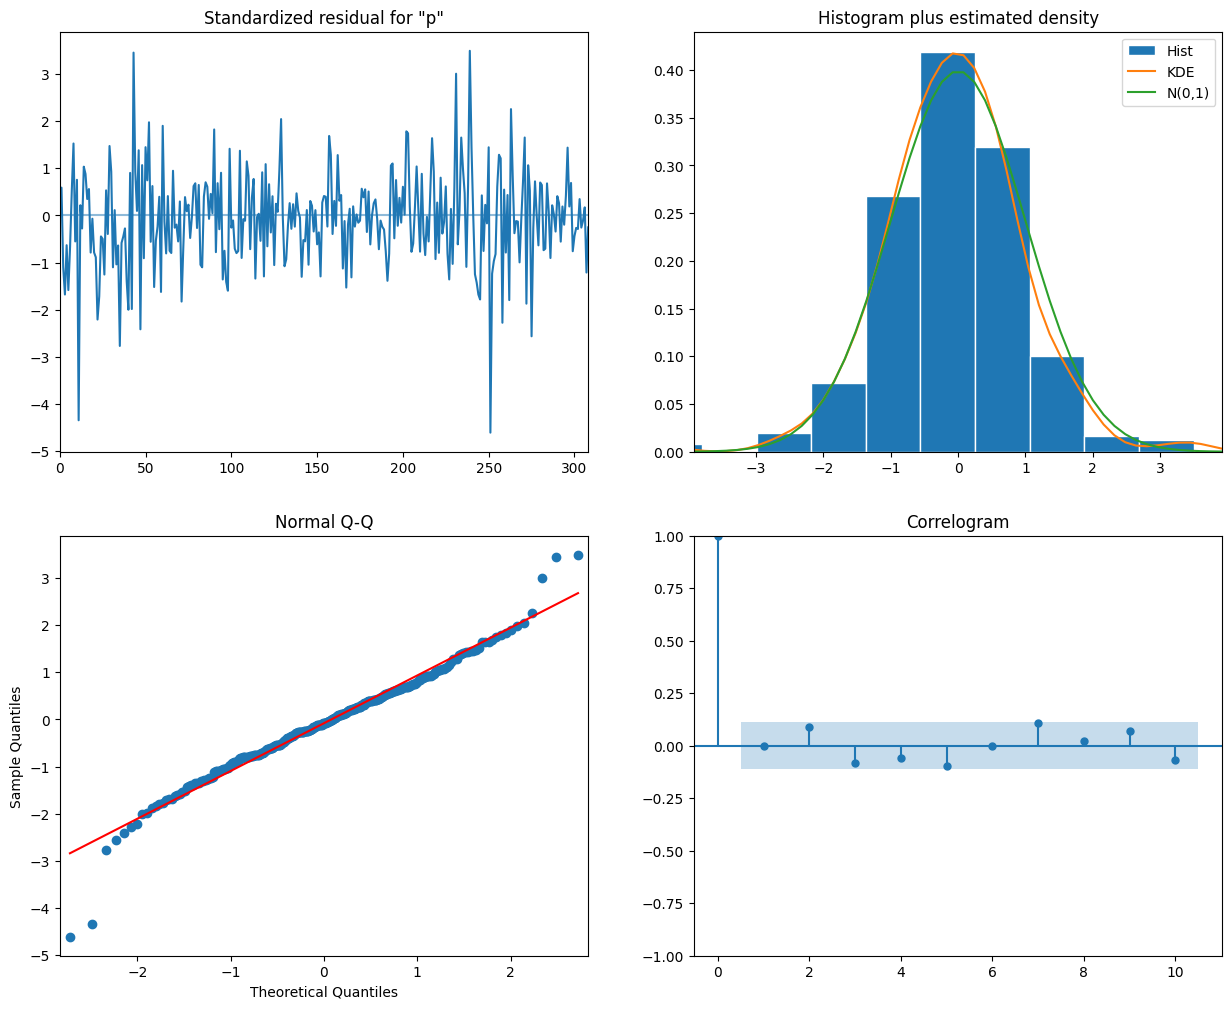

In [99]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

- KDE의 라인이 정규분포를 따른 것으로 보아, 잔차는 정규분포를 따른다.
- qq-plot을 봤을 때 잔차(파란색 점)의 분포가 표준정규분포에서 가져온 선형 추세를 따른다.
- 자기상관을 확인했을 때에도 신뢰구간을 넘지 않는 것으로 보인다.

## 4. 예측

In [117]:
pred = result.get_prediction(start=pd.to_datetime('2020-11-24'), dynamic=False)
pred_ci = pred.conf_int()

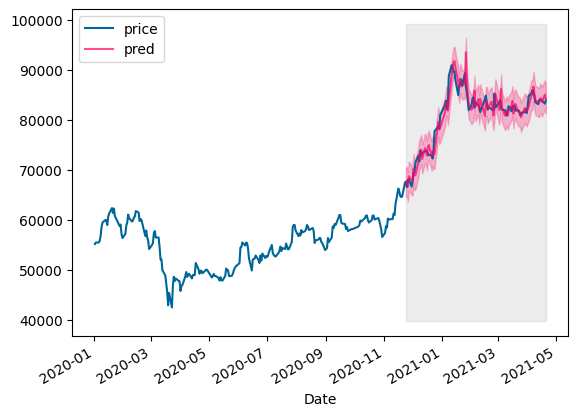

In [118]:
## Plot in-sample-prediction
ax = samsung_df['2020-01-02':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='pred', alpha=.7, color='#ff0066');

## Draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

## style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-11-24'), samsung_df.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date');
plt.legend(loc='upper left');
plt.show()

In [143]:
# 향후 100일 예측
fore_50 = pd.DataFrame(result.forecast(steps = 100))

In [144]:
fore_50.set_index(pd.date_range(start=pd.to_datetime('2021-04-21'), end=pd.to_datetime('2021-07-29'), freq='D'), inplace=True)

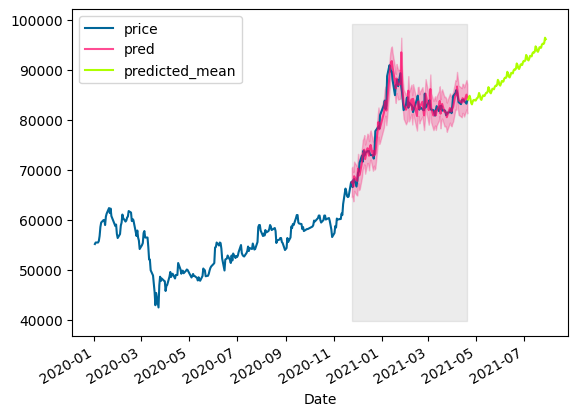

In [145]:
## Plot in-sample-prediction
ax = samsung_df['2020-01-02':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='pred', alpha=.7, color='#ff0066');
fore_50.plot(ax=ax, label='forecast', color='#aeff00')

## Draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

## style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-11-24'), samsung_df.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date');
plt.legend(loc='upper left');
plt.show()

In [160]:
from statsmodels.tools.eval_measures import rmse

예측 = list(pred.predicted_mean)
실제 = list(samsung_df['2020-11-24':]["price"])

arima_rmse_error = rmse(실제, 예측)
arima_mse_error = arima_rmse_error**2
mean_value = np.mean(실제)

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 2769371.071818601
RMSE Error: 1664.1427438229573
Mean: 80958.0
